In [1]:
import pandas as pd
from torch.utils import data
import numpy as np
import torch
import os
from PIL import Image
import random
import cv2

HEIGHT=288
WIDTH=512
mag = 1
sigma = 2.5


In [2]:

def genHeatMap(w, h, cx, cy, r, mag):
    if cx < 0 or cy < 0:
      return np.zeros((h, w))
    x, y = np.meshgrid(np.linspace(1, w, w), np.linspace(1, h, h))
    heatmap = ((y - (cy + 1))**2) + ((x - (cx + 1))**2)
    heatmap[heatmap <= r**2] = 1
    heatmap[heatmap > r**2] = 0
    return heatmap*mag


def getData(mode):
    if mode == 'train':
        img = pd.read_csv('tracknet_train_list_x_3.csv')
        label = pd.read_csv('tracknet_train_list_y_3.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('tracknet_test_list_x_3.csv')
        label = pd.read_csv('tracknet_test_list_y_3.csv')
        return np.squeeze(img.values), np.squeeze(label.values)


class TrackNetLoader(data.Dataset):
    def __init__(self, root, mode):
        self.root = root
        self.img_name, self.label_name = getData(mode)
        self.mode = mode
        img = Image.open(self.img_name[0][0]).convert('LA')
        w, h = img.size
        self.ratio = h / HEIGHT
        print("> Found %d data..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        img_path = self.img_name[index]
        label_path = self.label_name[index]
        img_all = []
        label_all = []
        for i in range(3):
            x = Image.open(img_path[i]).convert('RGB')
            x = x.resize((WIDTH, HEIGHT))
            
            x = np.asarray(x).transpose(2, 0, 1) / 255.0
            #x = x.resize((WIDTH, HEIGHT, 3))

            img_all.append(x[0])
            img_all.append(x[1])
            img_all.append(x[2])

            y = Image.open(label_path[i])
            y = np.asarray(y) / 255.0
            label_all.append(y)

        img_all = np.asarray(img_all)
        label_all = np.asarray(label_all)
        '''
        if self.mode == 'train':
          if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        '''
        return img_all, label_all

In [38]:
train_loader = TrackNetLoader('','train')

> Found 3273 data...


In [39]:
img_all, label_all = train_loader[50]

In [40]:
print(np.array(img_all).shape)
print(np.array(label_all).shape)

(9, 288, 512)
(3, 288, 512)


In [41]:
pil_image=Image.fromarray(np.array(label_all[2]))
pil_image.show()

In [42]:
def outcome(y_pred, y_true, tol):
    n = y_pred.shape[0]
    i = 0
    TP = TN = FP1 = FP2 = FN = 0
    while i < n:
        for j in range(1):
            if torch.max(y_pred[i][j]) == 0 and torch.max(y_true[i][j]) == 0:
                TN += 1
            elif torch.max(y_pred[i][j]) > 0 and torch.max(y_true[i][j]) == 0:
                FP2 += 1
            elif torch.max(y_pred[i][j]) == 0 and torch.max(y_true[i][j]) > 0:
                FN += 1
            elif torch.max(y_pred[i][j]) > 0 and torch.max(y_true[i][j]) > 0:
                h_pred = (y_pred[i][j] * 255).cpu().numpy()
                h_true = (y_true[i][j] * 255).cpu().numpy()
                h_pred = h_pred.astype('uint8')
                h_true = h_true.astype('uint8')


                #debug_img = cv2.hconcat([h_pred, h_true])

                #h_pred
                (cnts, _) = cv2.findContours(h_pred.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                rects = [cv2.boundingRect(ctr) for ctr in cnts]
                max_area_idx = 0
                max_area = rects[max_area_idx][2] * rects[max_area_idx][3]
                for j in range(len(rects)):
                    area = rects[j][2] * rects[j][3]
                    if area > max_area:
                        max_area_idx = j
                        max_area = area
                target = rects[max_area_idx]
                (cx_pred, cy_pred) = (int(target[0] + target[2] / 2), int(target[1] + target[3] / 2))

                #h_true
                (cnts, _) = cv2.findContours(h_true.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                rects = [cv2.boundingRect(ctr) for ctr in cnts]
                max_area_idx = 0
                max_area = rects[max_area_idx][2] * rects[max_area_idx][3]
                for j in range(len(rects)):
                    area = rects[j][2] * rects[j][3]
                    if area > max_area:
                        max_area_idx = j
                        max_area = area
                target = rects[max_area_idx]
                (cx_true, cy_true) = (int(target[0] + target[2] / 2), int(target[1] + target[3] / 2))
                dist = math.sqrt(pow(cx_pred-cx_true, 2)+pow(cy_pred-cy_true, 2))
                if dist > tol:
                    FP1 += 1
                else:
                    TP += 1
        i += 1
    return (TP, TN, FP1, FP2, FN)

def evaluation(TP, TN, FP1, FP2, FN):
    try:
        accuracy = (TP + TN) / (TP + TN + FP1 + FP2 + FN)
    except:
        accuracy = 0
    try:
        precision = TP / (TP + FP1 + FP2)
    except:
        precision = 0
    try:
        recall = TP / (TP + FN)
    except:
        recall = 0
    return (accuracy, precision, recall)

def WBCE(y_pred, y_true):
    eps = 1e-7
    loss = (-1)*(torch.square(1 - y_pred) * y_true * torch.log(torch.clamp(y_pred, eps, 1)) + torch.square(y_pred) * (1 - y_true) * torch.log(torch.clamp(1 - y_pred, eps, 1)))
    return torch.mean(loss)

def train(epoch):
    model.train()
    train_loss = 0
    TP = TN = FP1 = FP2 = FN = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.type(torch.FloatTensor).to(device)
        label = label.type(torch.FloatTensor).to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = WBCE(y_pred, label)

        #print('Train Epoch" {} [{}/{} ({:.0f}%)] \t Loss : {:.8f}'.format(epoch, (batch_idx+1) * len(data), len(train_loader.dataset),100.0 * (batch_idx+1) / len(train_loader), float(loss.data.cpu().numpy())))

        print('Train Epoch" {} [{}/{} ({:.0f}%)]'.format(epoch, (batch_idx+1) * len(data), len(train_loader.dataset),100.0 * (batch_idx+1) / len(train_loader))+'\tLoss :',format(float(loss.data.cpu().numpy()),'.1E'))


        #print('Train Epoch" {} [{}/{} ({:.0f}%)]\t'.format(epoch, (batch_idx+1) * len(data), len(train_loader.dataset),100.0 * (batch_idx+1) / len(train_loader)),"Loss :",float(loss.data.cpu().numpy())  )

        train_loss += loss.data
        #loss.backward()
        #optimizer.step()
        if(epoch % 1 == 0):
            y_pred = y_pred > 0.5
            (tp, tn, fp1, fp2, fn) = outcome(y_pred, label, tol)
            TP += tp
            TN += tn
            FP1 += fp1
            FP2 += fp2
            FN += fn

            #show(train_loss, epoch)
    train_loss /= len(train_loader)
    if(epoch % 1 == 0):
        display(TP, TN, FP1, FP2, FN)
        savefilename = save_weight + '_{}.tar'.format(epoch)
        torch.save({'epoch':epoch,'state_dict':model.state_dict(),},savefilename)
    return train_loss


def display(TP, TN, FP1, FP2, FN):
    print('======================Evaluate=======================')
    print("Number of true positive:", TP)
    print("Number of true negative:", TN)
    print("Number of false positive FP1:", FP1)
    print("Number of false positive FP2:", FP2)
    print("Number of false negative:", FN)
    (accuracy, precision, recall) = evaluation(TP, TN, FP1, FP2, FN)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print('=====================================================')



def show(train_loss):
    epoch_num = np.arange(1, epochs + 1, 1)
    plt.cla()
    plt.grid(True)
    plt.figure(figsize=(10, 8))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title('Loss of TrackNet3')
    train_loss_plt = plt.plot(epoch_num, train_loss, marker=".")
    plt.savefig('Loss_of_{}.jpg'.format(epoch))
    print('train loss : ' , train_loss)

In [43]:
# set train parameter

batchsize = 1
epochs = 30
lr = 1.
tol = 4
optimizer = 'Adadelta'
momentum = 0.9
weight_decay = 5e-4
seed = 1
load_weight = False
save_weight = 'custom'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU Use : ',torch.cuda.is_available())
train_data = TrackNetLoader('' , 'train')
train_loader = DataLoader(dataset = train_data, batch_size=batchsize, shuffle=True)
model = efficientnet_b3()
model.to(device)




GPU Use :  True
> Found 3273 data...


EfficientNet(
  (upsample): Upsample(scale_factor=1.3392857142857142, mode=bilinear)
  (upsample2): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(1536, 134, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(134, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (3): Swish(
      (sigmoid): Sigmoid()
    )
    (4): Conv2d(134, 134, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (5): BatchNorm2d(134, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (6): Swish(
      (sigmoid): Sigmoid()
    )
  )
  (upsample3): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(134, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(48, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (3): Swish(
      (sigmoid): Sigmoid()
    )
    (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (5): BatchNorm

In [ ]:
if optimizer == 'Adadelta':
    optimizer = torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0)
    #optimizer = torch.optim.Adam(model.parameters(), lr = args.lr, weight_decay = args.weight_decay)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay, momentum = momentum)

if(load_weight):
    print('======================Retrain=======================')
    checkpoint = torch.load(load_weight)
    model.load_state_dict(checkpoint['state_dict'])
    epoch = checkpoint['epoch']

train_loss = []

for epoch in range(1, epochs + 1):
    loss = train(epoch)
    train_loss.append(loss)

show(train_loss)

In [37]:
import gc
gc.collect()
torch.cuda.empty_cache()

del train_data
del train_loader
del model

NameError: name 'train_data' is not defined

In [44]:
1 % 1

0

In [17]:
a = np.random.rand(4,4,3)
b = np.random.rand(4,4,3)
c = np.random.rand(4,4,3)

In [18]:
unit = np.stack([a,b,c], axis=2)

In [19]:
unit.shape

(4, 4, 3, 3)

In [33]:
a[a<0.1]

array([0.08035313, 0.06188116, 0.00235755, 0.06389794])

In [36]:
a[np.where(a<0.1)]

array([0.08035313, 0.06188116, 0.00235755, 0.06389794])

In [2]:
import os
import argparse
from glob import glob

#parser = argparse.ArgumentParser(description = 'video_trans_img')
#parser.add_argument('--dataset', type = str, default='tennis_FOV_dataset', help = 'input your custom dataset folder path')
#args = parser.parse_args()

path = "./" + "tennis_FOV_dataset"
file_list = os.listdir(path)

In [4]:
p = os.path.join("tennis_FOV_dataset", game_list[0], 'frame', '1_00_02', '1.png')

NameError: name 'game_list' is not defined

In [5]:
p = os.path.join(path, file_list[0], 'rally_video', '*mp4')

In [6]:
os.listdir(path)

['match_4', 'match_6', 'match_5', 'match_3', 'match_1', 'match_2']

In [19]:
videoName = glob(p)

In [32]:
rallyName = videoName[0][len(os.path.join(file_list[0], 'rally_video'))+1:-4]

In [33]:
rallyName

'/match_4/rally_video/6'

In [31]:
len(os.path.join(file_list[0], 'rally_video'))+1

20

In [44]:
videoName[0][:-4]

'./tennis_FOV_dataset/match_4/rally_video/6'

In [45]:
output = videoName[0][:-4].split('/')
output

['.', 'tennis_FOV_dataset', 'match_4', 'rally_video', '6']

In [50]:
os.path.join(output[0] , output[1],output[2],'frame'  , output[4])

'./tennis_FOV_dataset/match_4/frame/6'

In [8]:
data = pd.read_csv("./tennis_FOV_dataset/match_1/ball_trajectory/1_ball.csv")
no = data['Frame'].values
v = data['Visibility'].values
x = data['X'].values
y = data['Y'].values
r = data['R'].values

In [10]:
r

array([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [11]:
a = (1280, 720)

In [13]:
a[1]/288

2.5

In [14]:
a[0]/512

2.5

In [18]:
(3/2.5) ** 2

1.44

In [20]:
np.round(np.sqrt(9/2.5))

2.0

In [17]:
import time

def tran_input_img(img_list):

    trans_img = []
    t0 = time.time()

    for i in range(len(img_list)):

        img = img_list[i]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = cv2.resize(img,(WIDTH, HEIGHT))
        img = np.asarray(img).transpose(2, 0, 1) / 255.0

        trans_img.append(img[0])
        trans_img.append(img[1])
        trans_img.append(img[2])

    trans_img = np.asarray(trans_img)
    t1 = time.time()
    
    print(t1 -t0)
    return trans_img.reshape(1,trans_img.shape[0],trans_img.shape[1],trans_img.shape[2])

In [18]:
a = np.zeros([288,512,3],dtype = 'uint8')
b = np.zeros([288,512,3],dtype = 'uint8')
c = np.zeros([288,512,3],dtype = 'uint8')
img_list = [a,b,c]

In [20]:
z = tran_input_img(img_list)

0.009733438491821289


In [21]:
import matplotlib.pyplot as plt


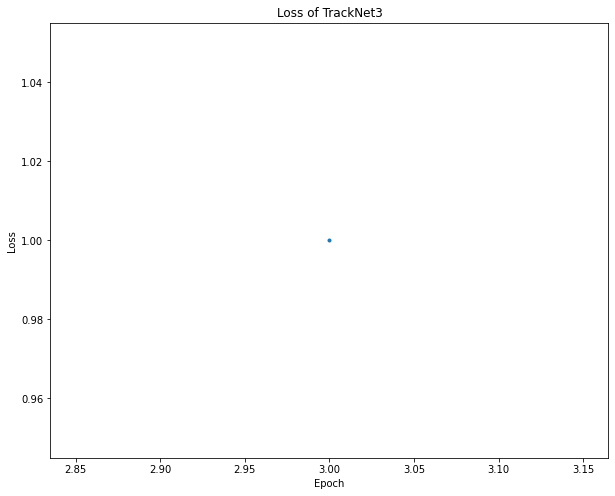

In [28]:
plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss of TrackNet3')
train_loss_plt = plt.plot(3, 1, marker=".")

plt.savefig('Loss_of_{}.jpg'.format(3))
